# V3: Shift-Based Anomaly Analysis & Model Tuning

This notebook focuses on analyzing behavioral patterns across three distinct shifts and optimizing the Isolation Forest model parameters for each.

### Shift Definitions:
- **Day Shift**: 09:00 - 16:59 (Hours 9-16)
- **Evening Shift**: 17:00 - 21:59 (Hours 17-21)
- **Night Shift**: 22:00 - 08:59 (Hours 22-23 and 0-8)

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.options.display.float_format = '{:,.4f}'.format

In [74]:
# Load the enriched data (Corrected path to full dataset)
df = pd.read_csv("../data/processed/enriched_logon.csv")
print(f"Total records loaded: {len(df)}")
df.head()

Total records loaded: 3366264


,user,window,logon_count,logoff_count,unique_pcs,hour,avg_logon,std_logon,avg_pcs,std_pcs,z_logon,z_pcs,night_flag,behavior_score
0,AAB0162,2010-01-04 07:00:00,1,0,1,7,0.4993,0.5004,1.0000,0.0000,1.0007,0.0000,False,0.4003
1,AAB0162,2010-01-04 18:00:00,0,1,1,18,0.4993,0.5004,1.0000,0.0000,-0.9979,0.0000,False,0.3992
2,AAB0162,2010-01-05 07:00:00,1,0,1,7,0.4993,0.5004,1.0000,0.0000,1.0007,0.0000,False,0.4003
3,AAB0162,2010-01-05 18:00:00,0,1,1,18,0.4993,0.5004,1.0000,0.0000,-0.9979,0.0000,False,0.3992
4,AAB0162,2010-01-06 07:00:00,1,0,1,7,0.4993,0.5004,1.0000,0.0000,1.0007,0.0000,False,0.4003


In [75]:
# 1. Define shift masks based on hour boundaries
day_mask     = (df['hour'] >= 9) & (df['hour'] <= 16)
evening_mask = (df['hour'] >= 17) & (df['hour'] <= 21)
night_mask   = (df['hour'] >= 22) | (df['hour'] <= 8)

# 2. Create shift dataframes
df_day_shift     = df[day_mask]
df_evening_shift = df[evening_mask]
df_night_shift   = df[night_mask]

# 3. Verify counts
print(f"Day Shift:     {len(df_day_shift):>8} records")
print(f"Evening Shift: {len(df_evening_shift):>8} records")
print(f"Night Shift:   {len(df_night_shift):>8} records")
print(f"Total:         {len(df_day_shift) + len(df_evening_shift) + len(df_night_shift):>8} records")

Day Shift:      1054891 records
Evening Shift:   894020 records
Night Shift:    1417353 records
Total:          3366264 records


## 1. Side-by-Side Statistical Comparison
Comparing the Mean and Max values for key metrics across shifts.

In [76]:
important_cols = ['avg_logon', 'avg_pcs', 'behavior_score']

def get_key_stats(df, name):
    stats = df[important_cols].agg(['mean', 'max']).T
    stats.columns = [f'{name}_Mean', f'{name}_Max']
    return stats

summary = pd.concat([
    get_key_stats(df_day_shift, 'Day'),
    get_key_stats(df_evening_shift, 'Evening'),
    get_key_stats(df_night_shift, 'Night')
], axis=1)

summary

,Day_Mean,Day_Max,Evening_Mean,Evening_Max,Night_Mean,Night_Max
avg_logon,0.5970,0.8967,0.5683,0.8967,0.5722,0.8967
avg_pcs,1.0101,1.1764,1.0116,1.1764,1.0132,1.1764
behavior_score,0.4135,9.9014,0.4678,9.2835,0.3999,9.7326


## 2. Visualizing Distributions
Boxplots to highlight differences in behavior across shifts.

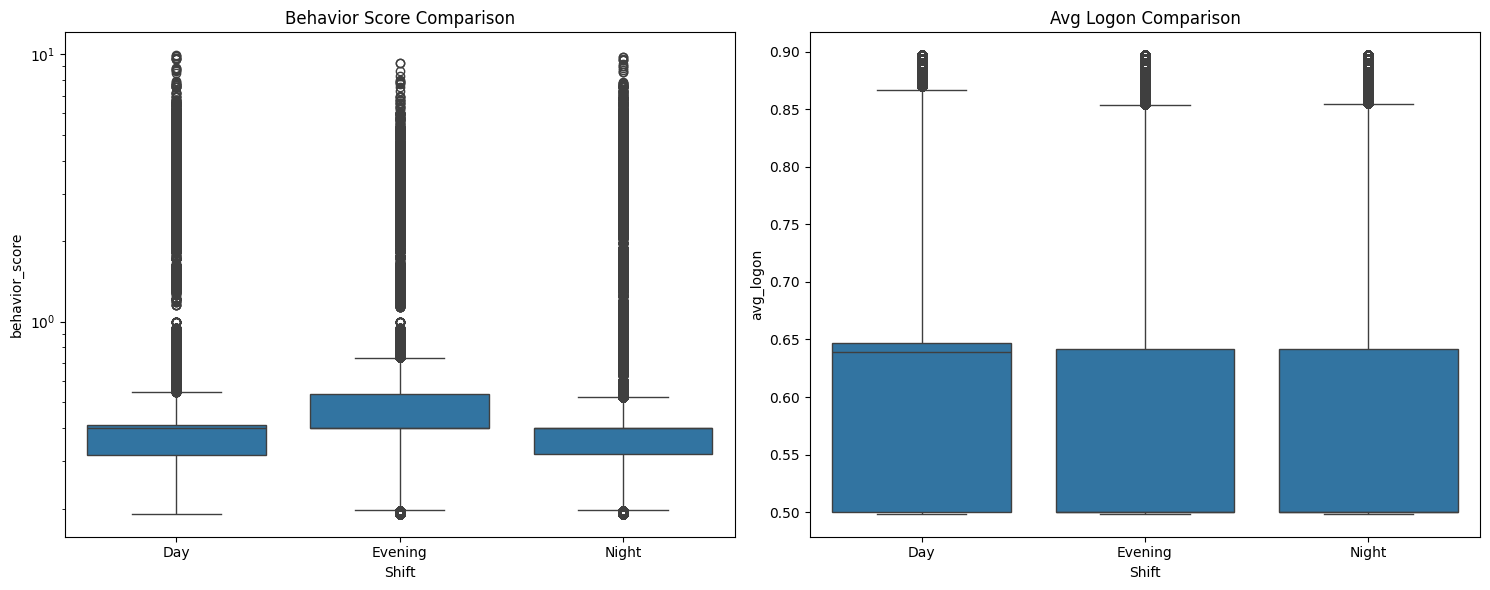

In [77]:
# Prepare for plotting
df_day_shift['Shift'] = 'Day'
df_evening_shift['Shift'] = 'Evening'
df_night_shift['Shift'] = 'Night'
combined_df = pd.concat([df_day_shift, df_evening_shift, df_night_shift])

plt.figure(figsize=(15, 6))

# Behavior Score Plot
plt.subplot(1, 2, 1)
sns.boxplot(data=combined_df, x='Shift', y='behavior_score')
plt.title('Behavior Score Comparison')
plt.yscale('log') # Log scale to better see the distribution

# Avg Logon Plot
plt.subplot(1, 2, 2)
sns.boxplot(data=combined_df, x='Shift', y='avg_logon')
plt.title('Avg Logon Comparison')

plt.tight_layout()
plt.show()

## 3. Hyperparameter Tuning (Isolation Forest)
Optimizing params for each shift by checking correlation with `behavior_score`.

In [78]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def apply_isolation_forest(df_shift, shift_name, n_estimators, contamination, max_samples):
    print(f"\n--- Applying model to {shift_name} Shift ---")
    
    features = ['logon_count', 'logoff_count', 'unique_pcs', 'z_logon', 'z_pcs']
    X = df_shift[features]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        max_samples=max_samples,
        random_state=42
    )
    
    # Fit model
    model.fit(X_scaled)
    
    # Get continuous scores
    scores = model.decision_function(X_scaled)
    
    # Get predictions
    predictions = model.predict(X_scaled)
    
    # Store results
    df_shift['if_score'] = scores
    df_shift['anomaly_prediction'] = predictions
    df_shift['is_anomaly'] = (predictions == -1)
    
    # Summary
    n_anomalies = (predictions == -1).sum()
    print(f"Total records: {len(df_shift):,}")
    print(f"Anomalies detected: {n_anomalies:,} ({n_anomalies/len(df_shift)*100:.2f}%)")
    
    # ---- Visualization 1: Score Distribution ----
    plt.figure(figsize=(10,6))
    sns.histplot(scores, bins=100, kde=True)
    plt.title(f"{shift_name} Shift - Decision Score Distribution")
    plt.xlabel("Decision Score")
    plt.ylabel("Frequency")
    plt.show()
    
    # ---- Visualization 2: Normal vs Anomaly ----
    normal_scores = scores[predictions == 1]
    anomaly_scores = scores[predictions == -1]
    
    plt.figure(figsize=(10,6))
    sns.histplot(normal_scores, bins=100, color='blue', label='Normal', alpha=0.6)
    sns.histplot(anomaly_scores, bins=100, color='red', label='Anomaly', alpha=0.6)
    plt.title(f"{shift_name} Shift - Normal vs Anomaly Distribution")
    plt.xlabel("Decision Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    return df_shift, model


In [79]:
day_params = {'n_estimators': 200, 'contamination': 'auto', 'max_samples': 'auto'} 
evening_params = {'n_estimators': 200, 'contamination': 'auto', 'max_samples': 'auto'} 
night_params = {'n_estimators': 200, 'contamination': 'auto', 'max_samples': 'auto'}


--- Applying model to Day Shift ---
Total records: 1,054,891
Anomalies detected: 218,010 (20.67%)


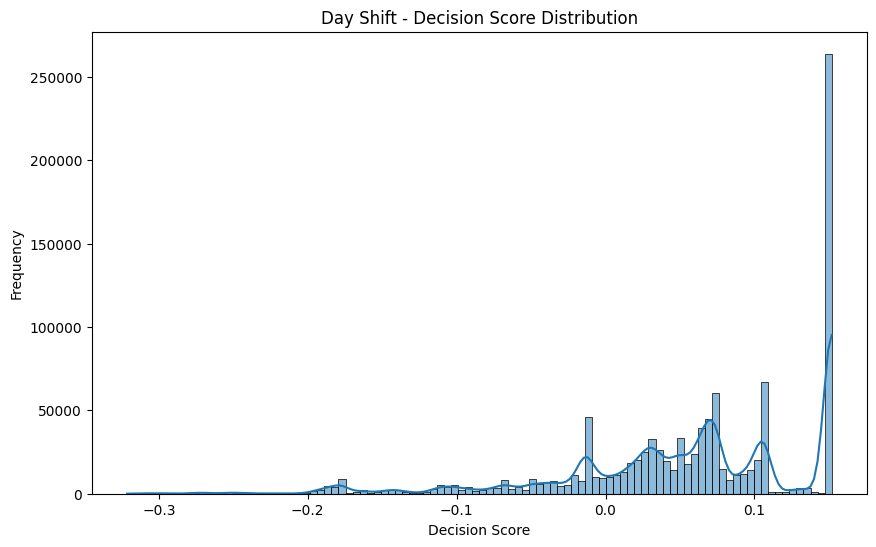

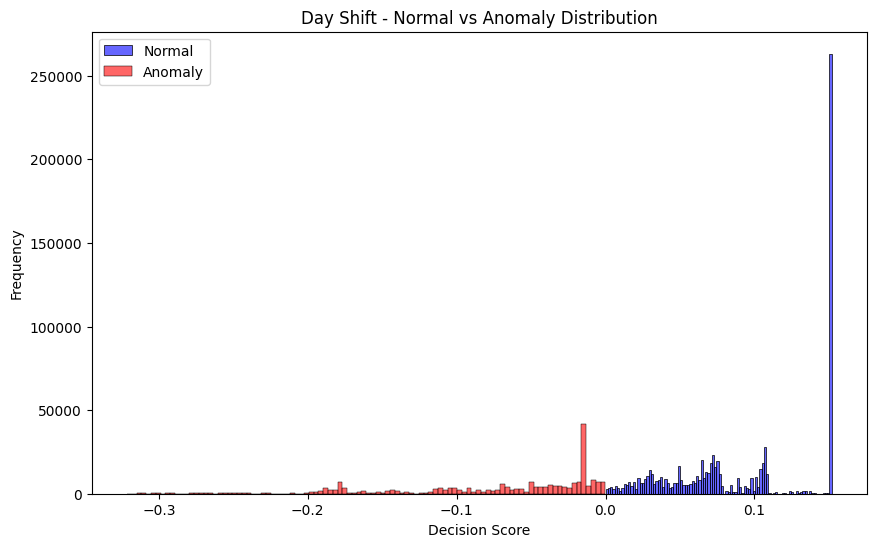


--- Applying model to Evening Shift ---
Total records: 894,020
Anomalies detected: 126,555 (14.16%)


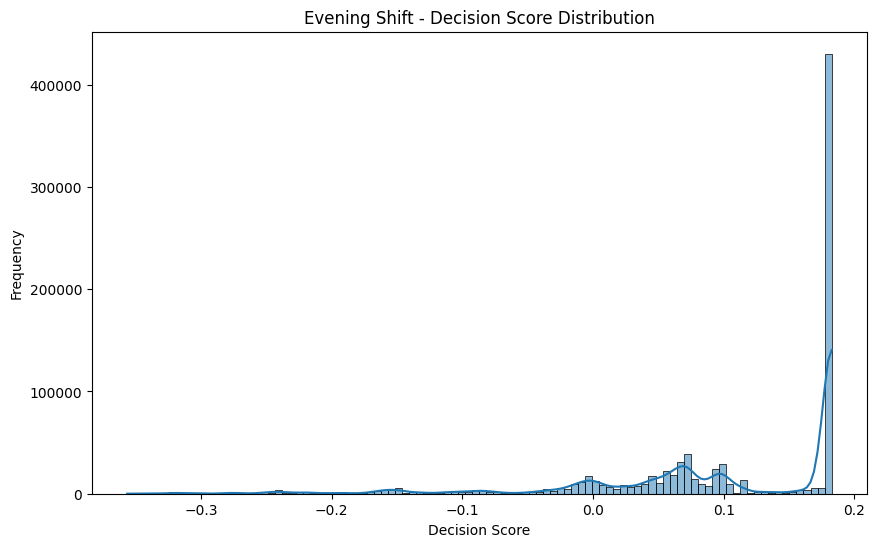

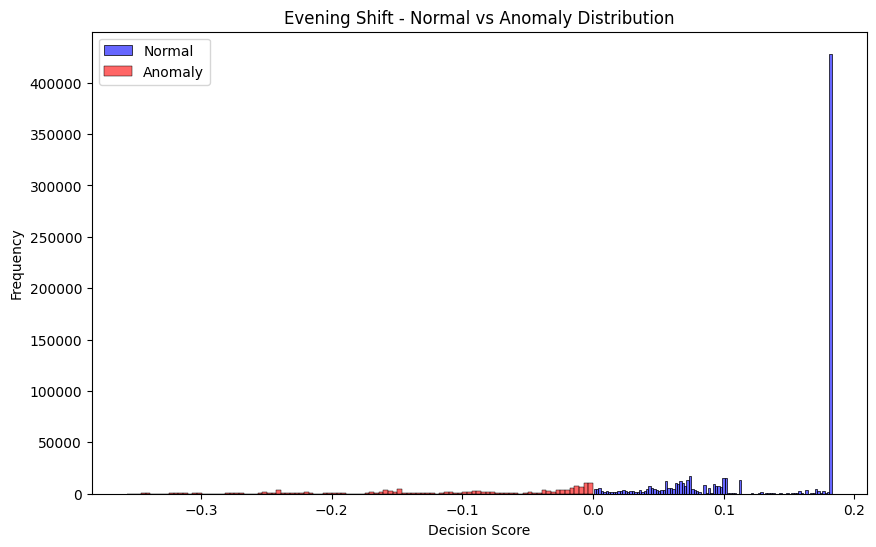


--- Applying model to Night Shift ---
Total records: 1,417,353
Anomalies detected: 155,898 (11.00%)


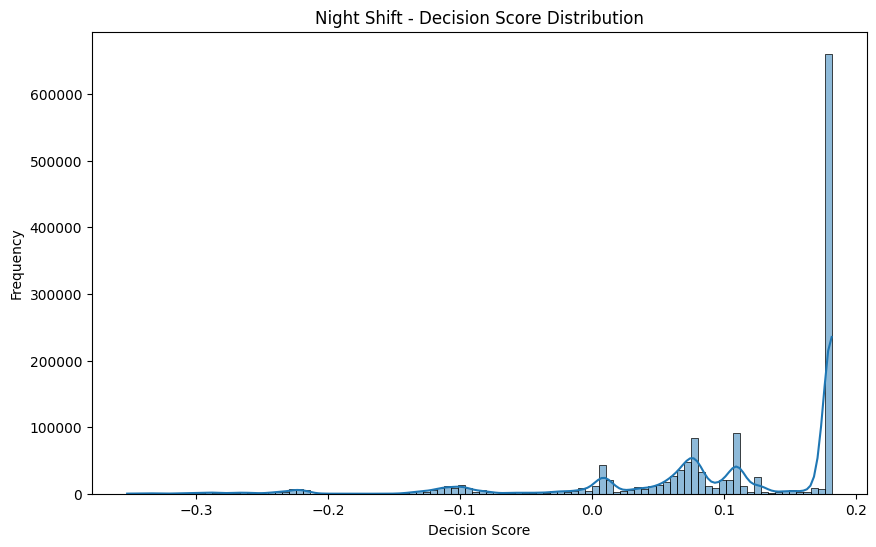

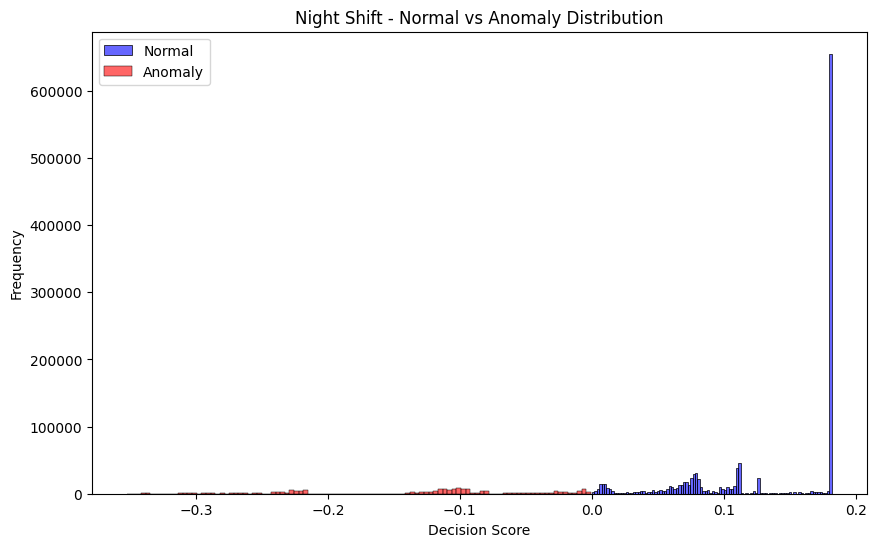

In [80]:
df_day_shift, model_day = apply_isolation_forest(df_day_shift, "Day", **day_params)
df_evening_shift, model_evening = apply_isolation_forest(df_evening_shift, "Evening", **evening_params)
df_night_shift, model_night = apply_isolation_forest(df_night_shift, "Night", **night_params)


In [81]:
# Analyze anomalies by user

print("=== ANOMALY ANALYSIS ===\n")

# Day Shift Anomalies
print("--- Day Shift Top Anomalous Users ---")
day_anomalies = df_day_shift[df_day_shift['is_anomaly'] == True]
day_user_anomalies = day_anomalies.groupby('user').size().sort_values(ascending=False).head(10)
print(day_user_anomalies)

print("\n--- Evening Shift Top Anomalous Users ---")
evening_anomalies = df_evening_shift[df_evening_shift['is_anomaly'] == True]
evening_user_anomalies = evening_anomalies.groupby('user').size().sort_values(ascending=False).head(10)
print(evening_user_anomalies)

print("\n--- Night Shift Top Anomalous Users ---")
night_anomalies = df_night_shift[df_night_shift['is_anomaly'] == True]
night_user_anomalies = night_anomalies.groupby('user').size().sort_values(ascending=False).head(10)
print(night_user_anomalies)

# View sample anomalies
print("\n--- Sample Anomalous Records (Day Shift) ---")
day_anomalies[['user', 'window', 'logon_count', 'unique_pcs', 'behavior_score', 'anomaly_prediction']].head(10)

=== ANOMALY ANALYSIS ===

--- Day Shift Top Anomalous Users ---
user
DNS1758    1023
HBB1759     862
ZJS1776     803
HDK0634     787
RLB1334     782
TCB0061     781
WBC1203     780
WBS3870     762
MBS1375     756
AJB1380     750
dtype: int64

--- Evening Shift Top Anomalous Users ---
user
TAM3048    781
MTS0465    755
EIR1046    685
RCF0044    655
SWH1053    654
EUC1051    644
FZB3046    643
CND3037    640
ALC1060    640
HYF1048    639
dtype: int64

--- Night Shift Top Anomalous Users ---
user
TAM3048    1211
MTS0465    1195
DNS1758    1160
RCF0044    1089
BPD2437    1069
KEF1057    1061
EUC1051    1047
CHB1062    1034
QGH0041    1017
JFG1049    1016
dtype: int64

--- Sample Anomalous Records (Day Shift) ---


,user,window,logon_count,unique_pcs,behavior_score,anomaly_prediction
1427,AAC0610,2010-01-05 16:00:00,0,1,0.5255,-1
1429,AAC0610,2010-01-06 16:00:00,0,1,0.5255,-1
1432,AAC0610,2010-01-07 16:00:00,0,1,0.5255,-1
1435,AAC0610,2010-01-08 16:00:00,0,1,0.5255,-1
1443,AAC0610,2010-01-13 16:00:00,0,1,0.5255,-1
1448,AAC0610,2010-01-15 16:00:00,0,1,0.5255,-1
1451,AAC0610,2010-01-18 16:00:00,0,1,0.5255,-1
1459,AAC0610,2010-01-21 16:00:00,0,1,0.5255,-1
1472,AAC0610,2010-01-28 16:00:00,0,1,0.5255,-1
1475,AAC0610,2010-01-29 16:00:00,0,1,0.5255,-1


In [82]:
df_day_shift['user'].nunique(),df_evening_shift['user'].nunique(),df_night_shift['user'].nunique()

(3013, 3088, 3899)

<h1>Performing Behavorial Clustering</h1>

In [83]:
df_day_shift.columns

Index(['user', 'window', 'logon_count', 'logoff_count', 'unique_pcs', 'hour',
       'avg_logon', 'std_logon', 'avg_pcs', 'std_pcs', 'z_logon', 'z_pcs',
       'night_flag', 'behavior_score', 'Shift', 'if_score',
       'anomaly_prediction', 'is_anomaly'],
      dtype='str')

In [84]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def build_user_profiles(df_shift):
    
    aggregations = {
        'logon_count': ['mean', 'std', 'sum'],   # mean, variability, total volume
        'unique_pcs': ['mean', 'std'],
        'hour': ['mean', 'std']
    }

    user_profile = df_shift.groupby('user').agg(aggregations)

    # Flatten column names
    user_profile.columns = [
        'mean_logon_count',
        'std_logon_count',
        'total_logon_volume',
        'mean_unique_pcs',
        'std_unique_pcs',
        'mean_activity_hour',
        'activity_hour_std'
    ]

    user_profile = user_profile.reset_index()

    # Replace NaN std (single observation users)
    user_profile = user_profile.fillna(0)

    # Optional: log transform volume to reduce skew
    user_profile['total_logon_volume'] = np.log1p(user_profile['total_logon_volume'])

    return user_profile


In [85]:
def cluster_users(user_profile, n_clusters=4, shift_name=None):
    
    features = user_profile.drop('user', axis=1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    user_profile['cluster_id'] = cluster_labels
    
    # ✅ SAVE THE SCALER
    if shift_name:
        import joblib
        import os
        os.makedirs('models', exist_ok=True)
        joblib.dump(scaler, f'models/v3_scaler_{shift_name}.pkl')
        print(f"✅ Saved scaler for {shift_name} shift")

    return user_profile, kmeans, scaler  # Return scaler too!



In [86]:
def merge_user_cluster_back(df_shift, user_profile):
    
    df_shift = df_shift.merge(
        user_profile[['user', 'cluster_id']],
        on='user',
        how='left'
    )

    return df_shift


In [87]:
user_profile_day, kmeans_day, scaler_day = cluster_users(user_profile_day, n_clusters=4, shift_name='day')
user_profile_evening, kmeans_evening, scaler_evening = cluster_users(user_profile_evening, n_clusters=4, shift_name='evening')
user_profile_night, kmeans_night, scaler_night = cluster_users(user_profile_night, n_clusters=4, shift_name='night')



✅ Saved scaler for day shift
✅ Saved scaler for evening shift
✅ Saved scaler for night shift


In [88]:
user_profile_day['cluster_id'].value_counts(normalize=True)


cluster_id
0   0.3707
3   0.2313
2   0.2200
1   0.1779
Name: proportion, dtype: float64

In [89]:
user_profile_day.groupby('cluster_id').mean(numeric_only=True)


,mean_logon_count,std_logon_count,total_logon_volume,mean_unique_pcs,std_unique_pcs,mean_activity_hour,activity_hour_std
cluster_id,,,,,,,
0,0.0036,0.0100,0.1353,1.0002,0.0020,15.6718,0.1504
1,0.7081,0.3982,5.6190,1.0263,0.1568,12.9293,1.8679
2,0.5203,0.4619,4.9293,1.0024,0.0283,13.5589,2.0807
3,0.9929,0.0451,5.2590,1.0010,0.0130,11.0168,0.8604


In [91]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import joblib
import json
import os

def train_cluster_specific_iforest(df, features, shift_name, contamination='auto'):
    """
    Trains a unique Isolation Forest for each cluster in the dataset.
    NOW ALSO SAVES MODELS AND THRESHOLDS!
    
    Args:
        df: The merged dataframe (hourly rows with 'cluster_id' column).
        features: List of column names to use for training.
        shift_name: 'day', 'evening', or 'night'
        contamination: The expected proportion of outliers in the data.
        
    Returns:
        df: The dataframe with 'cluster_if_score' and 'cluster_anomaly' columns.
    """
    # Create directories
    os.makedirs('models', exist_ok=True)
    
    # Create copies to store results
    df = df.copy()
    df['cluster_if_score'] = 0.0
    df['cluster_if_pred'] = 0
    
    # Dictionary to store thresholds
    thresholds = {}
    
    # Get unique clusters
    clusters = df['cluster_id'].unique()
    
    for cluster_id in clusters:
        # 1. Filter data for the specific cluster
        cluster_data = df[df['cluster_id'] == cluster_id]
        
        # 2. Skip if the cluster is too small to train on
        if len(cluster_data) < 10:
            continue
            
        # 3. Initialize and train Isolation Forest
        model = IsolationForest(
            n_estimators=100,
            contamination=contamination,
            random_state=42
        )
        
        # 4. Fit and predict
        model.fit(cluster_data[features])
        
        # Decision function: lower scores = more anomalous
        scores = model.decision_function(cluster_data[features])
        # Predict: -1 for anomaly, 1 for normal
        preds = model.predict(cluster_data[features])
        
        # 5. Map results back to the original dataframe using indices
        df.loc[cluster_data.index, 'cluster_if_score'] = scores
        df.loc[cluster_data.index, 'cluster_if_pred'] = preds
        
        # 6. ✅ SAVE THE MODEL
        model_filename = f'models/v3_{shift_name}_cluster_{cluster_id}_if.pkl'
        joblib.dump(model, model_filename)
        
        # 7. ✅ COMPUTE AND STORE THRESHOLD (1st percentile)
        threshold = pd.Series(scores).quantile(0.01)
        thresholds[f"cluster_{cluster_id}"] = float(threshold)
    
    # 8. ✅ SAVE THRESHOLDS FOR THIS SHIFT
    threshold_filename = f'models/v3_{shift_name}_thresholds.json'
    with open(threshold_filename, 'w') as f:
        json.dump(thresholds, f, indent=2)
    
    print(f"✅ Saved {len(thresholds)} IF models and thresholds for {shift_name} shift")
    
    # Convert predictions to 0 (normal) and 1 (anomaly) for easier reading
    df['is_cluster_anomaly'] = df['cluster_if_pred'].apply(lambda x: 1 if x == -1 else 0)
    
    return df

# --- EXECUTION ---
# Build profiles
user_profile_day = build_user_profiles(df_day_shift)
user_profile_evening = build_user_profiles(df_evening_shift)
user_profile_night = build_user_profiles(df_night_shift)

# Cluster (now also saves scalers)
user_profile_day, kmeans_day, scaler_day = cluster_users(user_profile_day, n_clusters=4, shift_name='day')
user_profile_evening, kmeans_evening, scaler_evening = cluster_users(user_profile_evening, n_clusters=4, shift_name='evening')
user_profile_night, kmeans_night, scaler_night = cluster_users(user_profile_night, n_clusters=4, shift_name='night')

# ⚠️ IMPORTANT: Merge cluster_id back to the shift dataframes FIRST
df_day_shift = merge_user_cluster_back(df_day_shift, user_profile_day)
df_evening_shift = merge_user_cluster_back(df_evening_shift, user_profile_evening)
df_night_shift = merge_user_cluster_back(df_night_shift, user_profile_night)

# NOW you can run the Isolation Forest training (which needs cluster_id column)
features_to_use = [
    'logon_count',
    'logoff_count',
    'unique_pcs',
    'z_logon',
    'z_pcs'
]

df_final_day = train_cluster_specific_iforest(df_day_shift, features_to_use, 'day')
df_final_evening = train_cluster_specific_iforest(df_evening_shift, features_to_use, 'evening')
df_final_night = train_cluster_specific_iforest(df_night_shift, features_to_use, 'night')

✅ Saved scaler for day shift
✅ Saved scaler for evening shift
✅ Saved scaler for night shift
✅ Saved 4 IF models and thresholds for day shift
✅ Saved 4 IF models and thresholds for evening shift
✅ Saved 4 IF models and thresholds for night shift


In [92]:
# Save feature configuration
feature_config = {
    "clustering_features": [
        'mean_logon_count',
        'std_logon_count',
        'total_logon_volume',
        'mean_unique_pcs',
        'std_unique_pcs',
        'mean_activity_hour',
        'activity_hour_std'
    ],
    "isolation_forest_features": features_to_use,
    "version": "v3",
    "n_estimators": 100,
    "contamination": "auto"
}

with open('models/v3_feature_config.json', 'w') as f:
    json.dump(feature_config, f, indent=2)

print("✅ Feature configuration saved")
print(json.dumps(feature_config, indent=2))

✅ Feature configuration saved
{
  "clustering_features": [
    "mean_logon_count",
    "std_logon_count",
    "total_logon_volume",
    "mean_unique_pcs",
    "std_unique_pcs",
    "mean_activity_hour",
    "activity_hour_std"
  ],
  "isolation_forest_features": [
    "logon_count",
    "logoff_count",
    "unique_pcs",
    "z_logon",
    "z_pcs"
  ],
  "version": "v3",
  "n_estimators": 100,
  "contamination": "auto"
}


In [93]:
print("Result for Day shift\n")

original_rate = (df_final_day['is_anomaly'] == True).mean()
print("Original Global IF anomaly rate:", original_rate)
new_rate = (df_final_day['cluster_if_pred'] == -1).mean()
print("Per-Cluster IF overall anomaly rate:", new_rate)

print("\nResult for Evening shift\n")
original_rate = (df_final_evening['is_anomaly'] == True).mean()
print("Original Global IF anomaly rate:", original_rate)
new_rate = (df_final_evening['cluster_if_pred'] == -1).mean()
print("Per-Cluster IF overall anomaly rate:", new_rate)

print("\nResult for Night shift\n")

original_rate = (df_final_night['is_anomaly'] == True).mean()
print("Original Global IF anomaly rate:", original_rate)
new_rate = (df_final_night['cluster_if_pred'] == -1).mean()
print("Per-Cluster IF overall anomaly rate:", new_rate)

Result for Day shift

Original Global IF anomaly rate: 0.20666590197470638
Per-Cluster IF overall anomaly rate: 0.1649459517618408

Result for Evening shift

Original Global IF anomaly rate: 0.14155723585602112
Per-Cluster IF overall anomaly rate: 0.22940538242992325

Result for Night shift

Original Global IF anomaly rate: 0.10999235899595937
Per-Cluster IF overall anomaly rate: 0.2533553744197811


In [94]:
df_day_shift.columns


Index(['user', 'window', 'logon_count', 'logoff_count', 'unique_pcs', 'hour',
       'avg_logon', 'std_logon', 'avg_pcs', 'std_pcs', 'z_logon', 'z_pcs',
       'night_flag', 'behavior_score', 'Shift', 'if_score',
       'anomaly_prediction', 'is_anomaly', 'cluster_id'],
      dtype='str')

In [95]:
df_final_day.groupby('user')['cluster_if_pred'].apply(lambda x: (x == -1).mean()).describe()


count   3,013.0000
mean        0.2123
std         0.3918
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0883
max         1.0000
Name: cluster_if_pred, dtype: float64

In [96]:
user_anomaly_rates = df_final_day.groupby('user')['cluster_if_pred'].apply(lambda x: (x == -1).mean())

print((user_anomaly_rates > 0.5).sum())



604


In [97]:
df_final_day['cluster_if_score'].describe()


count   1,054,891.0000
mean            0.0866
std             0.1033
min            -0.3770
25%             0.0376
50%             0.1044
75%             0.1512
max             0.2014
Name: cluster_if_score, dtype: float64

In [98]:
df_final_day.groupby('cluster_id')['cluster_if_score'].describe()


,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,"317,482.0000",0.1579,0.1099,-0.3770,0.2014,0.2014,0.2014,0.2014
1,"287,902.0000",0.0357,0.0731,-0.3009,0.0138,0.0522,0.0951,0.1166
2,"263,756.0000",0.0599,0.0862,-0.3224,0.0080,0.0911,0.1247,0.1444
3,"185,751.0000",0.0812,0.0856,-0.3196,0.0557,0.1226,0.1400,0.1512


In [99]:
df_day_shift.columns

Index(['user', 'window', 'logon_count', 'logoff_count', 'unique_pcs', 'hour',
       'avg_logon', 'std_logon', 'avg_pcs', 'std_pcs', 'z_logon', 'z_pcs',
       'night_flag', 'behavior_score', 'Shift', 'if_score',
       'anomaly_prediction', 'is_anomaly', 'cluster_id'],
      dtype='str')

In [100]:
user_anomaly_rates = (
    df_final_day.groupby('user')['is_cluster_anomaly']
    .mean()
)

print(user_anomaly_rates.describe())
print((user_anomaly_rates > 0.5).sum())


count   3,013.0000
mean        0.2123
std         0.3918
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0883
max         1.0000
Name: is_cluster_anomaly, dtype: float64
604


In [101]:
alerts = 0
for cid in df_final_day['cluster_id'].unique():
    cluster_scores = df_final_day[df_final_day['cluster_id']==cid]['cluster_if_score']
    thresh = cluster_scores.quantile(0.01)
    alerts += (cluster_scores < thresh).sum()

print("Alert rate:", alerts / len(df_final_day))


Alert rate: 0.00927773580398354


In [102]:
#checking if hybrid model is necessary

for cid in df_final_day['cluster_id'].unique():
    cluster_scores = df_final_day[df_final_day['cluster_id']==cid]['cluster_if_score']
    thresh = cluster_scores.quantile(0.01)
    cluster_alerts = (cluster_scores < thresh).sum()
    print(cid, cluster_alerts)


0 2785
1 2609
3 1837
2 2556


<h2>checking the same with the other two shifts</h2>

In [103]:

total_alerts_evening = 0

for cid in df_final_evening['cluster_id'].unique():
    cluster_scores = df_final_evening[df_final_evening['cluster_id']==cid]['cluster_if_score']
    thresh = cluster_scores.quantile(0.01)
    cluster_alerts = (cluster_scores < thresh).sum()
    print("Cluster", cid, "alerts:", cluster_alerts)
    total_alerts_evening += cluster_alerts

print("Evening alert rate:", total_alerts_evening / len(df_final_evening))


Cluster 0 alerts: 5655
Cluster 3 alerts: 2730
Cluster 2 alerts: 28
Cluster 1 alerts: 503
Evening alert rate: 0.009972931254334355


In [104]:
total_alerts_night = 0

for cid in df_final_night['cluster_id'].unique():
    cluster_scores = df_final_night[df_final_night['cluster_id']==cid]['cluster_if_score']
    thresh = cluster_scores.quantile(0.01)
    cluster_alerts = (cluster_scores < thresh).sum()
    print("Cluster", cid, "alerts:", cluster_alerts)
    total_alerts_night += cluster_alerts

print("Night alert rate:", total_alerts_night / len(df_final_night))


Cluster 2 alerts: 11189
Cluster 0 alerts: 1468
Cluster 3 alerts: 7
Cluster 1 alerts: 927
Night alert rate: 0.009589001469640944


<h2>Checking the distribution of the cluster is 0.01</h2>

In [105]:
for cid in df_final_evening['cluster_id'].unique():
    cluster_data = df_final_evening[df_final_evening['cluster_id']==cid]
    cluster_size = len(cluster_data)
    thresh = cluster_data['cluster_if_score'].quantile(0.01)
    cluster_alerts = (cluster_data['cluster_if_score'] < thresh).sum()
    print(cid, cluster_alerts / cluster_size)


0 0.009995828442948655
3 0.009932726697204648
2 0.010237659963436929
1 0.009921104536489152


In [106]:
for cid in df_final_night['cluster_id'].unique():
    cluster_data = df_final_night[df_final_night['cluster_id']==cid]
    cluster_size = len(cluster_data)
    thresh = cluster_data['cluster_if_score'].quantile(0.01)
    cluster_alerts = (cluster_data['cluster_if_score'] < thresh).sum()
    print(cid, cluster_alerts / cluster_size)


2 0.009518502764780945
0 0.009962335855586849
3 0.007683863885839737
1 0.009905221879107142


<h2>Saving all the necessary artifacts</h2>

In [107]:
# Save user profiles for each shift
import os
os.makedirs('artifacts', exist_ok=True)

user_profile_day.to_csv('artifacts/v3_user_profile_day.csv', index=False)
user_profile_evening.to_csv('artifacts/v3_user_profile_evening.csv', index=False)
user_profile_night.to_csv('artifacts/v3_user_profile_night.csv', index=False)

print("✅ User profiles saved")

✅ User profiles saved


In [108]:
# Save KMeans models
import joblib
os.makedirs('models', exist_ok=True)

joblib.dump(kmeans_day, 'models/v3_kmeans_day.pkl')
joblib.dump(kmeans_evening, 'models/v3_kmeans_evening.pkl')
joblib.dump(kmeans_night, 'models/v3_kmeans_night.pkl')

print("✅ KMeans models saved")

✅ KMeans models saved
